# Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import io
from bs4 import BeautifulSoup

from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
from tabulate import tabulate


from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Question 1- Programmatically download and load into your favorite analytical tool the trip data for September 2015. Report how many rows and columns of data you have loaded.

In [3]:
link = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'

In [4]:
s = requests.get(link).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [5]:
df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


In [6]:
print ("Number of rows:", df.shape[0])
print ("Number of columns: ", df.shape[1])

Number of rows: 1494926
Number of columns:  21


# Question 2: •	Plot a histogram of the number of the trip distance (“Trip Distance”) and Report any structure you find and any hypotheses you have about that structure.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Count')

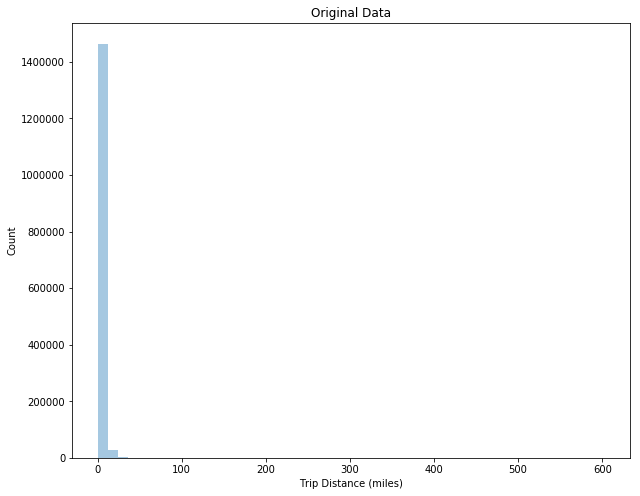

In [7]:
plt.figure(figsize=(10,8))
sns.distplot(df.Trip_distance, kde = False)
plt.title("Original Data")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Count")

The above histogram does not illustrate our data properly. Hence, we will plot the raw Trip distance on logarithmic scale as well as remove the outliers from Trip Distance and plot the data points for better visualization. 
Here, outliers are defined as data point located outside 3 standard deviations from the median.

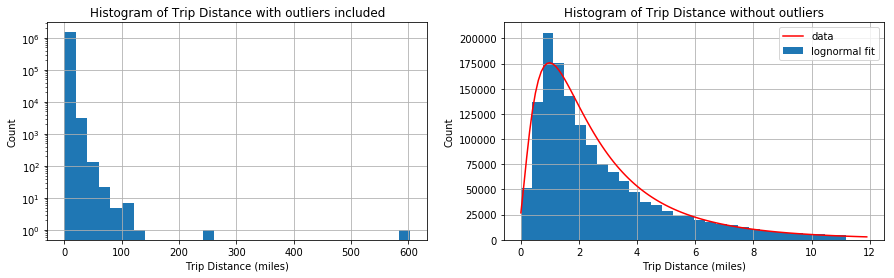

In [8]:
# define the figure with 2 subplots
fig, ax = plt.subplots(1,2,figsize = (15,4)) 

# histogram of the number of trip distance
df.Trip_distance.hist(bins=30, ax=ax[0])
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Distance with outliers included')

#histogram of number of trip distance without outliers
Trip_distance_median = df.Trip_distance.median()
Trip_distance_sd = df.Trip_distance.std()
df[~((df.Trip_distance-Trip_distance_median) > 3*Trip_distance_sd)].Trip_distance.hist(bins=30, ax=ax[1])
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Trip Distance without outliers')

# apply a lognormal fit. Use the mean of trip distance as the scale parameter
scatter,loc,mean = lognorm.fit(df.Trip_distance.values,
                               scale=df.Trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),600000*pdf_fitted,'r') 
ax[1].legend(['data','lognormal fit'])


plt.show()

# The NYC Green Taxi was commissioned to pick up street hail passengers in areas not commonly served by yellow medallion cabs. The goal of the Green Taxi program is to improve access to street-hail transportation throughout the five boroughs in areas of New York City historically underserved by the yellow taxi industry. Since it is targeted to street hail passengers, we can hypothesize that the majority of the trips will be short distance.  The above histogram informs that the distribution of Trip distance for NYC Green taxi data is not normally distributed and skewed towards right, i.e. 88% of our data are short distance trips (within 6 miles).


# Question 3.a: Mean and Median Trip Distance group by hour of the day

In [9]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['Pickup_Hour_Day'] = df['lpep_pickup_datetime'].dt.hour

df_temp = df.groupby('Pickup_Hour_Day')['Trip_distance'].agg(['mean', 'median'])
print ('Mean and Median of Trip distance grouped by pickup hour of the day\n')
print(df_temp)

Mean and Median of Trip distance grouped by pickup hour of the day

                     mean  median
Pickup_Hour_Day                  
0                3.115276    2.20
1                3.017347    2.12
2                3.046176    2.14
3                3.212945    2.20
4                3.526555    2.36
5                4.133474    2.90
6                4.055149    2.84
7                3.284394    2.17
8                3.048450    1.98
9                2.999105    1.96
10               2.944482    1.92
11               2.912015    1.88
12               2.903065    1.89
13               2.878294    1.84
14               2.864304    1.83
15               2.857040    1.81
16               2.779852    1.80
17               2.679114    1.78
18               2.653222    1.80
19               2.715597    1.85
20               2.777052    1.90
21               2.999189    2.03
22               3.185394    2.20
23               3.191538    2.22


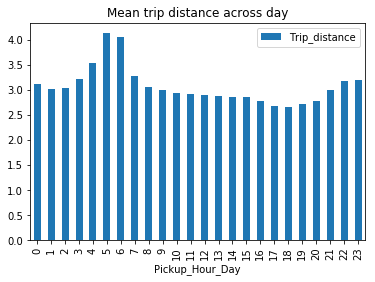

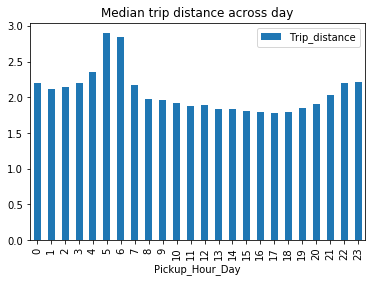

In [10]:
df[['Trip_distance','Pickup_Hour_Day']].groupby('Pickup_Hour_Day').mean().plot.bar()
plt.title('Mean trip distance across day')
plt.show()
df[['Trip_distance','Pickup_Hour_Day']].groupby('Pickup_Hour_Day').median().plot.bar()
plt.title('Median trip distance across day')
plt.show()

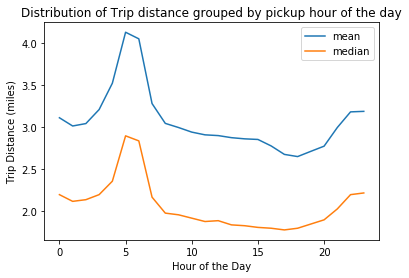

In [11]:
df_temp.plot()
plt.title("Distribution of Trip distance grouped by pickup hour of the day")
plt.xlabel("Hour of the Day")
plt.ylabel("Trip Distance (miles)")
plt.show()

# Question 3.b: We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criterion, the average fare, and any other interesting characteristics of these trips?

# The data dictionary indicates that RateCodeID column indicates the area of final rate. I will be using this column for airport area. 2 = JFK and 3 = Newark

In [12]:
airports_area_df = df[(df.RateCodeID==2) | (df.RateCodeID==3)]
print('The number of trips that originate or terminate at one of the NYC area airports is', len(airports_area_df))
print('The average fare of trips originating or terminating in NYC airports area is', airports_area_df['Fare_amount'].mean())
print('The average total amounts charged for trips originating or terminating in NYC airports area is', airports_area_df['Total_amount'].mean())

The number of trips that originate or terminate at one of the NYC area airports is 5552
The average fare of trips originating or terminating in NYC airports area is 48.976945244956774
The average total amounts charged for trips originating or terminating in NYC airports area is 57.20842038904719


# This was a very brute force approach. We can take a more sophisticated one to find out trips originating or terminating in the NYC airports area.  In the below section, we are making use of the pickup and dropoff longitude and latitude information. We are making an assumption that any latitude and longitude within the 5 miles radius of any of the three NYC airports (JFK, LaGuardia and Newark) are marked as  airport area. We will use python math library to calculate the distance between two given longitude and latitude. 

In [13]:
#Extracting the latitude and longitude information for each NYC airports
geolocator = Nominatim(user_agent="https://www.mayankajha.com/")

location = geolocator.geocode("John F. Kennedy International Airport NYC")
JFK_lat = location.latitude
JFK_lon = location.longitude

location = geolocator.geocode("LaGuardia Airport")
LGA_lat = location.latitude
LGA_lon = location.longitude

location = geolocator.geocode("Newark International Airport")
EWR_lat = location.latitude
EWR_lon = location.longitude

In [14]:
#Defining a function which calculates the distance between two longitude and latitude points in miles
from math import sin, cos, sqrt, atan2, radians
def distance(origin, destination):

    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d * 0.621371192

In [15]:
#Defining a function which calculates the distance between the NYC airports longitude and latitude and pickup and dropoff latitude and longitude data points 
def test_airport(row):
    pickup_distance_JFK = distance((row['Pickup_latitude'],row['Pickup_longitude']), (JFK_lat, JFK_lon))
    dropoff_distance_JFK = distance((row['Dropoff_latitude'],row['Dropoff_longitude']), (JFK_lat, JFK_lon))
    pickup_distance_LGA = distance((row['Pickup_latitude'],row['Pickup_longitude']), (LGA_lat, LGA_lon))
    dropoff_distance_LGA = distance((row['Dropoff_latitude'],row['Dropoff_longitude']), (LGA_lat, LGA_lon))
    pickup_distance_EWR = distance((row['Pickup_latitude'],row['Pickup_longitude']), (EWR_lat, EWR_lon))
    dropoff_distance_EWR = distance((row['Dropoff_latitude'],row['Dropoff_longitude']), (EWR_lat, EWR_lon))
    temp = [pickup_distance_JFK, dropoff_distance_JFK, pickup_distance_LGA, dropoff_distance_LGA, 
           pickup_distance_EWR, dropoff_distance_EWR]
    return any(i <= 1 for i in temp)

In [16]:
from tqdm import tqdm
import math
tqdm.pandas()
df['Near_Airport'] = df.progress_apply(test_airport, axis=1)

100%|██████████| 1494926/1494926 [05:31<00:00, 4509.95it/s]


In [17]:
df['Near_Airport'].value_counts()

False    1450977
True       43949
Name: Near_Airport, dtype: int64

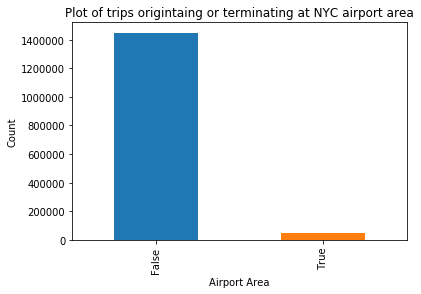

In [18]:
df['Near_Airport'].value_counts().plot(kind = "bar")
plt.title("Plot of trips origintaing or terminating at NYC airport area")
plt.xlabel("Airport Area")
plt.ylabel("Count")
plt.show()

In [19]:
df.groupby('Near_Airport')[["Fare_amount", "Total_amount"]].agg(["mean", "median", "min", "max", np.std])

Fare_amount                                 Total_amount         \
                    mean median    min    max        std         mean median   
Near_Airport                                                                   
False          12.128541    9.5 -475.0  580.5   9.495778    14.525869   11.3   
True           26.233087   22.5  -45.0  450.0  16.970860    31.746895   28.5   

                                       
                min    max        std  
Near_Airport                           
False        -475.0  581.3  10.767754  
True          -45.0  450.0  20.601498

# Ques 4: •	Build a derived variable for tip as a percentage of the total fare. Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample and show your work.

Before we build our derived variable and build our predictive model for tip as the percentage of total fare, we will explore the columns of interest. We will be focussing on columns - Trip distance, Tip amount, Payment Type, Total amount, Pickup hour, pickup week, drop-off hour and drop-off week¶

The steps are: Data Cleaning - replacing null values, na values and invalid data with median for continuous variable and most frequent values for categorical variable, 
Treating outliers for continuous variable by replacing them with median.
Feature Engineering - Creating four new column using pickup and drop-off datetime: pickup hour, drop-off hour, pickup week, drop-off week.

In [20]:
#Feature Engineering

df['Lpep_dropoff_datetime'] = pd.to_datetime(df['Lpep_dropoff_datetime'])
#df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

#df['Pickup_Hour'] = df['lpep_pickup_datetime'].dt.hour
df['Dropoff_Hour'] = df['Lpep_dropoff_datetime'].dt.hour

df['Dropoff_Week'] = df['Lpep_dropoff_datetime'].dt.weekday
df['Pickup_Week'] = df['lpep_pickup_datetime'].dt.weekday

In [21]:
df_new = df[['Tip_amount', 'Trip_distance', 'Payment_type', 'Total_amount','Pickup_Hour_Day','Dropoff_Hour', 'Dropoff_Week', 'Pickup_Week']]

In [22]:
df_new.isnull().sum()

Tip_amount         0
Trip_distance      0
Payment_type       0
Total_amount       0
Pickup_Hour_Day    0
Dropoff_Hour       0
Dropoff_Week       0
Pickup_Week        0
dtype: int64

In [23]:
df_new.isna().sum()

Tip_amount         0
Trip_distance      0
Payment_type       0
Total_amount       0
Pickup_Hour_Day    0
Dropoff_Hour       0
Dropoff_Week       0
Pickup_Week        0
dtype: int64

In [24]:
df_new.describe()

,Tip_amount,Trip_distance,Payment_type,Total_amount,Pickup_Hour_Day,Dropoff_Hour,Dropoff_Week,Pickup_Week
count,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06
mean,1.235727e+00,2.968141e+00,1.540559e+00,1.503215e+01,1.353407e+01,1.347794e+01,3.175485e+00,3.175590e+00
std,2.431476e+00,3.076621e+00,5.232935e-01,1.155316e+01,6.799624e+00,6.892356e+00,1.966505e+00,1.962202e+00
min,-5.000000e+01,0.000000e+00,1.000000e+00,-4.750000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.100000e+00,1.000000e+00,8.160000e+00,9.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000e+00,1.980000e+00,2.000000e+00,1.176000e+01,1.500000e+01,1.500000e+01,3.000000e+00,3.000000e+00
75%,2.000000e+00,3.740000e+00,2.000000e+00,1.830000e+01,1.900000e+01,1.900000e+01,5.000000e+00,5.000000e+00
max,3.000000e+02,6.031000e+02,5.000000e+00,5.813000e+02,2.300000e+01,2.300000e+01,6.000000e+00,6.000000e+00


# Payment Type - As per Data Dictionary, we have tip amount only if the payment is done using credit card otherwise it does not get registered. Hence, we will build our predictive model using data points which have payment type as credit card, i.e. 1

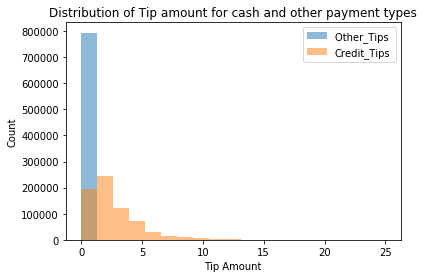

In [25]:
Other_Tips = df.Tip_amount[df.Payment_type.isin([2,3,4,5,6])]
Credit_Tips = df.Tip_amount[df.Payment_type == 1]
bins = np.linspace(0, 25, 20)
plt.hist(Other_Tips , bins, alpha=0.5, label='Other_Tips ')
plt.hist(Credit_Tips, bins, alpha=0.5, label='Credit_Tips')
plt.title("Distribution of Tip amount for cash and other payment types")
plt.xlabel("Tip Amount")
plt.ylabel("Count")
plt.legend(loc='upper right')
plt.show()

In [26]:
df_final = df_new[df_new.Payment_type == 1]

Text(0, 0.5, 'Count')

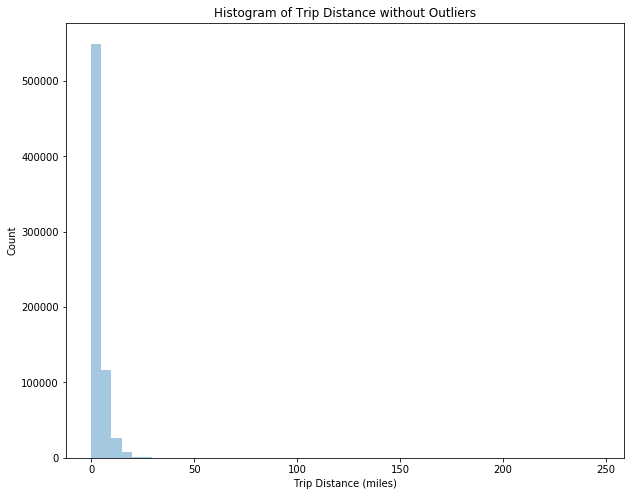

In [27]:
#Data Exploration for Cleaning - Trip_distance

plt.figure(figsize=(10,8))
sns.distplot(df_final.Trip_distance, kde = False)
plt.title("Histogram of Trip Distance without Outliers")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Count")

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0, 0.5, 'Count')

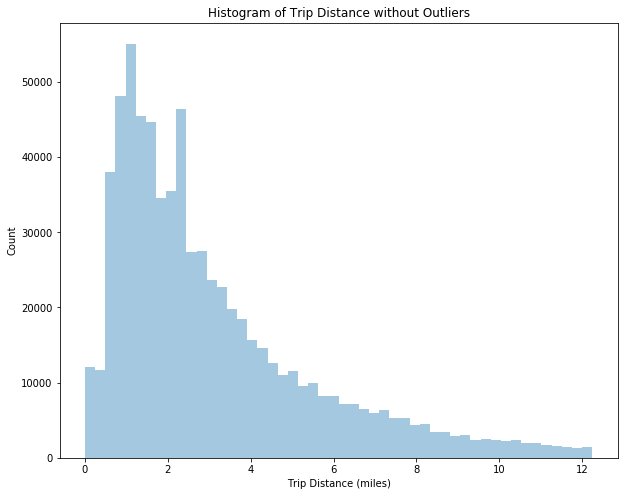

In [28]:
#Data Cleaning - Trip Distance has outliers and I will remove that 

Trip_distance_median = df_final.Trip_distance.median()
Trip_distance_sd = df_final.Trip_distance.std()

df_final.Trip_distance = np.where((df_final.Trip_distance-Trip_distance_median) > 3*Trip_distance_sd, Trip_distance_median, df_final.Trip_distance)

plt.figure(figsize=(10,8))
sns.distplot(df_final.Trip_distance, kde = False)
plt.title("Histogram of Trip Distance without Outliers")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Count")

In [29]:
df_final.Total_amount.describe()

count    701287.000000
mean         18.116779
std          12.826788
min          -5.760000
25%           9.950000
50%          14.300000
75%          22.450000
max         497.550000
Name: Total_amount, dtype: float64

Text(0, 0.5, 'Count')

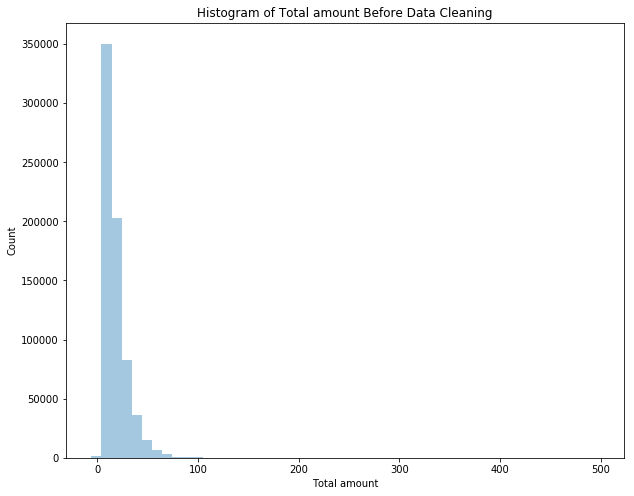

In [30]:
plt.figure(figsize=(10,8))
sns.distplot(df_final.Total_amount, kde = False)
plt.title("Histogram of Total amount Before Data Cleaning")
plt.xlabel("Total amount")
plt.ylabel("Count")

In [31]:
#removing outliers
Total_amount_median = df_final.Total_amount.median()
Total_amount_sd = df_final.Total_amount.std()

df_final.Total_amount = np.where((df_final.Total_amount-Total_amount_median) > 3*Total_amount_sd, Total_amount_median, df_final.Total_amount)

In [32]:
#treating invalid data points - replacing negative values in this column with median
df_final.Total_amount = np.where(df_final.Total_amount <=0, Total_amount_median, df_final.Total_amount)

Text(0, 0.5, 'Count')

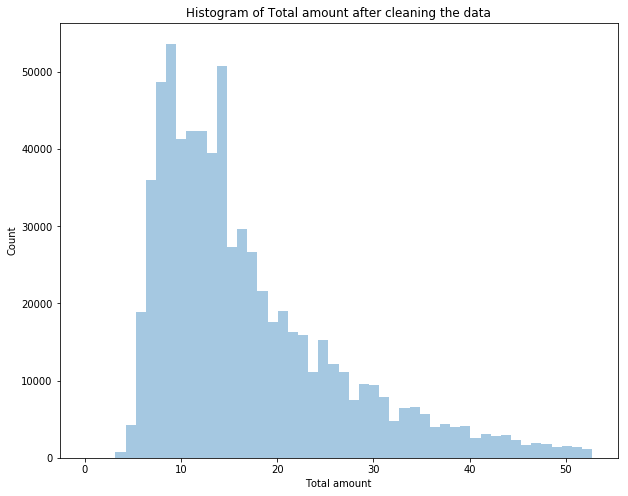

In [33]:
plt.figure(figsize=(10,8))
sns.distplot(df_final.Total_amount, kde = False)
plt.title("Histogram of Total amount after cleaning the data")
plt.xlabel("Total amount")
plt.ylabel("Count")

In [34]:
df_final.Tip_amount.describe()

count    701287.000000
mean          2.634134
std           2.980382
min          -0.960000
25%           1.160000
50%           2.000000
75%           3.360000
max         300.000000
Name: Tip_amount, dtype: float64

Text(0, 0.5, 'Count')

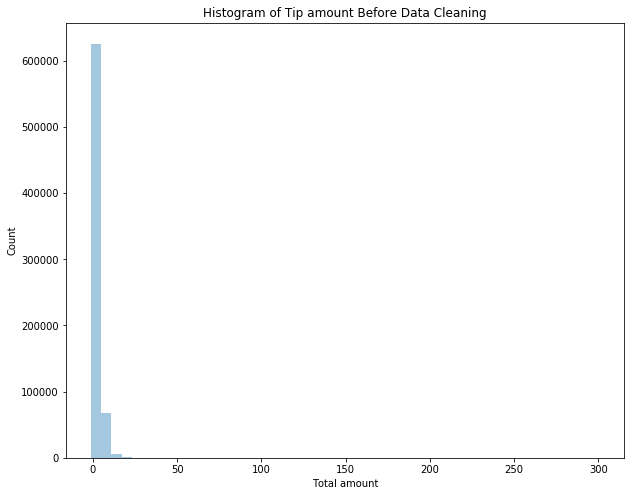

In [35]:
plt.figure(figsize=(10,8))
sns.distplot(df_final.Tip_amount, kde = False)
plt.title("Histogram of Tip amount Before Data Cleaning")
plt.xlabel("Total amount")
plt.ylabel("Count")

In [36]:
#removing outliers
Tip_amount_median = df_final.Tip_amount.median()
Tip_amount_sd = df_final.Tip_amount.std()

df_final.Tip_amount = np.where((df_final.Tip_amount-Tip_amount_median) > 3*Tip_amount_sd, Tip_amount_median, df_final.Tip_amount)

In [37]:
#treating invalid data points - replacing negative values in this column with median
df_final.Tip_amount = np.where(df_final.Tip_amount <=0, Tip_amount_median, df_final.Tip_amount)

Text(0, 0.5, 'Count')

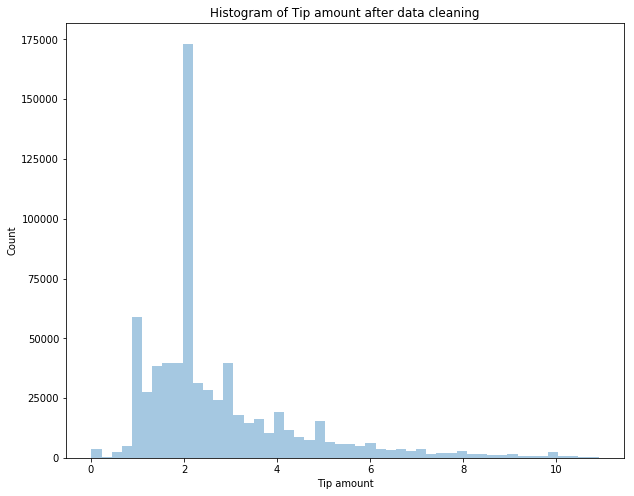

In [38]:
plt.figure(figsize=(10,8))
sns.distplot(df_final.Tip_amount, kde = False)
plt.title("Histogram of Tip amount after data cleaning")
plt.xlabel("Tip amount")
plt.ylabel("Count")

In [39]:
df_final.Tip_amount.describe()

count    701287.000000
mean          2.728571
std           1.713984
min           0.010000
25%           1.750000
50%           2.000000
75%           3.260000
max          10.910000
Name: Tip_amount, dtype: float64

# Ques 4.a : Build a derived variable for tip as a percentage of the total fare

In [40]:
df_final['Tip_Percentage'] = (100*df_final.Tip_amount)/df_final.Total_amount
print ("Tip percentage summary\n",df_final.Tip_Percentage.describe())

Tip percentage summary
 count    701287.000000
mean         17.103499
std          42.150955
min           0.019681
25%          14.492754
50%          16.666667
75%          19.780220
max       20000.000000
Name: Tip_Percentage, dtype: float64


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# The above result shows that the max value for Tip Percentage is 20000. This indicates that some of our data point has Total amount less than Tip Amount. This might be due to the fact that New Yorkers were really generous or some coupons were applied for their payment or some corrupt data. We will drop these rows.

In [41]:
df_final.loc[df_final.Tip_Percentage > 100, ]

,Tip_amount,Trip_distance,Payment_type,Total_amount,Pickup_Hour_Day,Dropoff_Hour,Dropoff_Week,Pickup_Week,Tip_Percentage
198419,2.0,0.00,1,1.06,3,3,5,5,188.679245
301112,2.0,0.00,1,0.18,0,1,0,0,1111.111111
502805,2.0,0.00,1,1.11,12,12,4,4,180.180180
502965,2.0,0.00,1,0.01,12,12,4,4,20000.000000
596576,2.0,0.00,1,0.12,21,21,5,5,1666.666667
759833,2.0,0.03,1,0.12,11,11,2,2,1666.666667
801162,2.0,0.00,1,1.00,9,9,3,3,200.000000
801212,2.0,0.00,1,1.30,9,9,3,3,153.846154
801916,2.0,2.63,1,1.14,9,9,3,3,175.438596
1093354,2.0,0.00,1,1.00,18,18,1,1,200.000000


In [42]:
df_final1 = df_final[df_final.Total_amount > df_final.Tip_amount]

# Now that we have prepared our data, dropped invalid points. We will build a Linear Regression base model with only Total amount as independent variable and Tip Percentage as dependent variable

In [43]:
#checking columns indexes
cols = ['Total_amount', 'Tip_Percentage']
[df_final1.columns.get_loc(c) for c in cols if c in df_final1]

[3, 8]

# Importing Scikit Libraries

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [45]:
X = df_final1.iloc[:, [3]].values
y = df_final1.iloc[:, 8].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0 )

In [46]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [47]:
lr = LinearRegression(fit_intercept = False)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [48]:
y_pred = lr.predict(X_test)

# We are choosing Root Mean Square Error as our performance metric

In [49]:
np.sqrt(mean_squared_error(y_test, y_pred))

18.393590273570375

In [50]:
df_final1.Tip_Percentage.describe()

count    701224.000000
mean         17.000808
std           7.235528
min           0.019681
25%          14.492754
50%          16.666667
75%          19.780220
max          90.909091
Name: Tip_Percentage, dtype: float64

# The Linear Regression model gave a RMSE val of 18.39 and the mean tip percentage is only 17%. This means our linear regression model is not good. This indicates a non linear relationship between our independent variable and dependent variable. Hence, I will build a Random Forest model

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
y_pred = rf.predict(X_test)

In [54]:
pd.Series(y_pred).describe()

count    140245.000000
mean         16.991678
std           4.719955
min           0.044615
25%          15.241985
50%          16.666667
75%          18.494769
max          66.363636
dtype: float64

In [55]:
np.sqrt(mean_squared_error(y_test, y_pred))

5.546988030521573

# Now, that we have a better model. I am going to see if adding more variables improve the model

In [56]:
#I will use one hot encoding for our categorical values dropoff hour, dropoff week, pickup week and pickup hour¶

X = df_final1.iloc[:, [1,3,4,5,6,7]].values
y = df_final1.iloc[:, 8].values

In [57]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
label_encoder_3 = LabelEncoder()
label_encoder_4 = LabelEncoder()
label_encoder_5 = LabelEncoder()

label_encoder.fit(X[:,2]) #never enter multiple column here, it doesn't work
X[:,2] = label_encoder.transform(X[:,2])

label_encoder_3.fit(X[:,3]) #never enter multiple column here, it doesn't work
X[:,3] = label_encoder_3.transform(X[:,3])

label_encoder_4.fit(X[:,4]) #never enter multiple column here, it doesn't work
X[:,4] = label_encoder_4.transform(X[:,4])

label_encoder_5.fit(X[:,5]) #never enter multiple column here, it doesn't work
X[:,5] = label_encoder_5.transform(X[:,5])

one_hot_encoder = OneHotEncoder(categorical_features=[2,3,4,5], sparse=False)
one_hot_encoder.fit(X)
X= one_hot_encoder.transform(X)

X = np.delete(X, one_hot_encoder.feature_indices_[ : -1], 1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function feature_indices_ is dep

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0 ) 
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [59]:
y_pred = rf.predict(X_test)
pd.Series(y_pred).describe()

count    140245.000000
mean         16.982945
std           5.690690
min           0.069881
25%          14.673607
50%          16.666667
75%          18.574297
max          69.896853
dtype: float64

In [61]:
np.sqrt(mean_squared_error(y_test, y_pred))

5.2176639498349235

# Adding new variable did not improve our RMSE value by much. This means the additional features are not adding any value to the model. Hence, the simple rf model can be deemed the best model. 